E:\Documents\MMU Studies\Python Scripts\Track LOST dataset


<IPython.core.display.Javascript object>


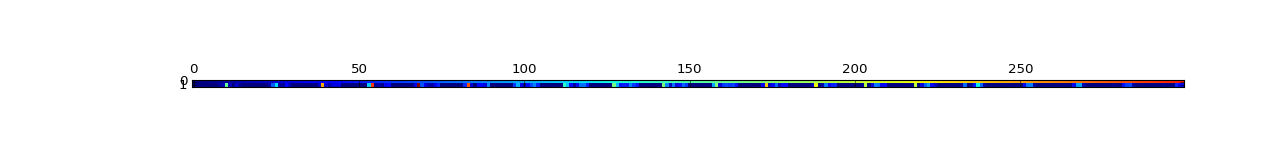

In [141]:
import pandas as pd
import numpy as np
import cv2
from sklearn.cluster import KMeans
from pandas import Series, DataFrame, Panel
import matplotlib.pyplot as plt
import matplotlib.figure as fig
import matplotlib.image as mpimg
from matplotlib import collections as mc 
import os

import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO

##################################### Tunable Variables ###########################################
days_to_process = 7
pd.options.display.max_rows = 10
###################################################################################################

#####################################string variables##############################################
dayArray = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17'
,'18','19','20','21','22','23','24','25','26','27','28','29','30','31']
monthArray = ['01','02','03','04','05','06','07','08','09','10','11','12',]
# Tunable Variables
# currentYear = 2013 # input 1
# pointerMonth = n n1	   # input 2
# pointerDay = 0   # input 3

currentYear = 2013
currentMonth = monthArray[0]
currentDay = dayArray[0]
pointerMonth = 0
pointerDay = 0
daysToChoose = 5
#####################################################################################################

###############################string concatenation & Load Data########################
counter = 0
frames = pd.DataFrame()
os.chdir('E:\Documents\MMU Studies\Python Scripts\Track LOST dataset')
currentIndex = 1 # This variable is used to reindex every dataframe
print(os.getcwd())
listDay = []
while counter < daysToChoose:
    stringDate = '001_' + str(currentYear) + str(currentMonth) + str(currentDay) + '.txt' 
    string_to_be_parsed = "pd.read_table('" + stringDate + "',delimiter=' ', header=None, names=col_names)"
    try:
        exec("%s%d = %s" % ("day", counter, string_to_be_parsed))
        tempString_Date = eval("%s%d" % ("day", counter))
        tempString_Date, currentIndex = trackID_reindex(tempString_Date, currentIndex)
        frames = frames.append(tempString_Date)
        tempFrames = frames[['X', 'Y']]
        listDay += [tempFrames]
    except:
        print("Not Found")
    counter += 1
    currentYear, currentMonth, currentDay, pointerMonth, pointerDay = calendarFunction(currentYear, currentMonth, currentDay, pointerMonth, pointerDay)
#######################################################################################
col_names = ['TrackID','FrameNo', 'X', 'Y']
concatDay = frames.sort_values(by='TrackID', ascending=True)
concatDay = concatDay.reset_index(drop=True)
os.chdir('E:\Documents\MMU Studies\Python Scripts')
# np.set_printoptions(threshold=np.nan)
# heatmap_data = constructHeatmap(concatDay)


counter = 0
np_vector_heatmap = []
while counter < daysToChoose:
#     print(listDay[counter])
    heatmap_data = constructHeatmap(listDay[counter])
    vector_heatmap, sum_array = heatmapPooling(heatmap_data, 32)
    np_vector_heatmap += [vector_heatmap]
    counter += 1
np_vector_heatmap = np.asarray(np_vector_heatmap)

plt.matshow(sum_array)
plt.show()

In [140]:
def heatmapPooling(heatmapArray, pooling_dim):
    array_of_pooled_images = []
    yDim = heatmapArray.shape[0]
    xDim = heatmapArray.shape[1]
    pool_i = 0
    start_i = 0
    
    while start_i < yDim:
        pool_j = 0
        start_j = 0
        pool_i += pooling_dim
        while start_j < xDim:
            pool_j += pooling_dim
            pooled_image = heatmapArray[start_i:pool_i, start_j:pool_j]
            array_of_pooled_images += [pooled_image]
            start_j = pool_j
        start_i = pool_i
    array_of_pooled_images = np.array(array_of_pooled_images)
    vector_array_pooled_images = np.concatenate(array_of_pooled_images)
    vector_array_pooled_images = np.concatenate(vector_array_pooled_images)
#     sum_array = np.sum(array_of_pooled_images)
    rowCounter = 0
#     sum_array = np.empty([array_of_pooled_images.shape[0], 2])
    sum_array = []
    while rowCounter < array_of_pooled_images.shape[0]:
        sum_of_pool = array_of_pooled_images[rowCounter]
        sum_of_pool = np.sum(sum_of_pool)
#         sum_array = np.insert(sum_array, [rowCounter, 2], [rowCounter+1,sum_of_pool])
        sum_array += [(rowCounter),(sum_of_pool)]
        rowCounter += 1
    
    sum_array = np.asarray(sum_array)
    sum_array = np.reshape(sum_array, (300,2))
    sum_array = np.transpose(sum_array)
    return vector_array_pooled_images, sum_array

In [79]:
def histogram(heatmapArray):
    plt.figure
    hist_Heatmap = cv2.calcHist([heatmapArray], [3], None, [256], [0, 256])
    plt.plot(hist_Heatmap)
    plt.show()

In [117]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0, 0, 0])

def constructHeatmap(heatmapDataInput): 
    heatmapData = heatmapDataInput[['X','Y']]
    heatmapData = pd.DataFrame.as_matrix(heatmapData)
    heatmapData_X = heatmapDataInput[['X']]
    heatmapData_Y = heatmapDataInput[['Y']]
    heatmapData_X = pd.DataFrame.as_matrix(heatmapData_X)
    heatmapData_X = heatmapData_X.flatten()
    heatmapData_Y = pd.DataFrame.as_matrix(heatmapData_Y)
    heatmapData_Y = heatmapData_Y.flatten()
    
    heatmapData = heatmapData.flatten()

    #insert data for scaling the heatmap
    heatmapData_X = np.insert(heatmapData_X, [0], 0) #Min cap
    heatmapData_X = np.append(heatmapData_X, 640) #Max cap
    heatmapData_Y = np.insert(heatmapData_Y, [0], 0) #Min cap
    heatmapData_Y = np.append(heatmapData_Y, 480) #Max cap
    xmin = 0
    xmax = 640
    ymin = 0
    ymax = 480
    
    ########### hexbin approach ##########
#     %matplotlib notebook
# #     dataHeat = plt.hexbin(heatmapData_X, heatmapData_Y, gridsize=(640,480), xscale='linear', yscale='linear')
#     dataHeat = plt.hexbin(heatmapData_X, heatmapData_Y)
#     plt.axis([xmin, xmax, ymin, ymax])
# #     plt.colorbar()
#     plt.gca().invert_yaxis()
#     plt.savefig('heatmap.png')
    ######################################
    
    ########## try histogram2d approach ############
    dataHistogram = np.histogram2d(heatmapData_X, heatmapData_Y, bins=[640,480])
    ###########################################
    
    ##################### Overlaying image #########################
#     %matplotlib notebook
#     imageA = cv2.imread("heatmap.png")
#     dim = (640, 480)
#     imageA = cv2.resize(imageA, dim)
#     imageB = cv2.imread("overlayingImage.png")
#     imageC = cv2.add(imageA, imageB)
#     cv2.imshow("heatmap", imageC)
#     cv2.waitKey(0)
    return dataHistogram[0]


In [81]:
def trackID_reindex(dataframe_to_be_reindexed, currentIndex):
    counter = 1
    
    ## Newly indexed Series
    trackID_Series = dataframe_to_be_reindexed[['TrackID']]
    trackID_Series.loc[0].TrackID = currentIndex
    
    ## reference Series
    ref_Series = dataframe_to_be_reindexed[['TrackID']]
    initial_ID = ref_Series.loc[0].TrackID
    
    while counter < len(dataframe_to_be_reindexed):
        if ref_Series.loc[counter].TrackID == initial_ID:
            trackID_Series.loc[counter].TrackID = currentIndex
        else:
            currentIndex += 1
            trackID_Series.loc[counter].TrackID = currentIndex
            initial_ID = ref_Series.loc[counter].TrackID
        counter += 1
    currentIndex += 1 ##for new document
    dataframe_to_be_reindexed[['TrackID']] = trackID_Series    
    return dataframe_to_be_reindexed, currentIndex

In [82]:
def calendarFunction(currentYear, currentMonth, currentDay, pointerMonth, pointerDay):
    if (pointerMonth == 3) or (pointerMonth == 5) or (pointerMonth == 8) or (pointerMonth == 10):
        if currentDay == '30':
            currentDay = dayArray[0]
            pointerMonth += 1
            currentMonth = monthArray[pointerMonth]
            pointerDay = 0
        else:
            pointerDay += 1
            currentDay = dayArray[pointerDay]
            
    elif pointerMonth == 1:
        if (currentYear%4 == 0) and (currentDay == '28'):#leapyear
            pointerDay += 1
            currentDay = dayArray[pointerDay]
        elif (currentYear%4 == 0) and (currentDay == '29'):#reset to 01 if day ends for the month
            currentDay = dayArray[0]
            pointerDay = 0
            pointerMonth += 1
            currentMonth = monthArray[pointerMonth]
        elif (currentYear%4 != 0) and (currentDay == '28'): #Non Leap year
            currentDay = dayArray[0]
            pointerDay = 0
            pointerMonth += 1
            currentMonth = monthArray[pointerMonth]
        else:
            pointerDay += 1
            currentDay = dayArray[pointerDay]
    else: #for 31 days month
        if currentDay == '30':
            pointerDay += 1
            currentDay = dayArray[pointerDay]
        elif currentDay == '31':
            currentDay = dayArray[0]
            pointerDay = 0
            pointerMonth += 1
            currentMonth = monthArray[pointerMonth]
        else:
            pointerDay += 1
            currentDay = dayArray[pointerDay]

    #if year ends?
    if (pointerMonth == 11) and (pointerDay == 30):
        currentYear += 1
        pointerMonth = 0
        pointerDay = 0
        currentMonth = monthArray[pointerMonth]
        currentDay = dayArray[pointerDay]
    return currentYear, currentMonth, currentDay, pointerMonth, pointerDay
    